In [466]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [469]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [347]:
warnings.filterwarnings("ignore")

In [348]:
df = pd.read_csv('../data/sensor1.csv')

In [349]:
df = df.dropna()

In [350]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [351]:
df['Time'] = pd.to_datetime(df['Time'])

In [352]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [353]:
df = df.sort_index()

In [354]:
temperature = df["Temperature (°C)"]

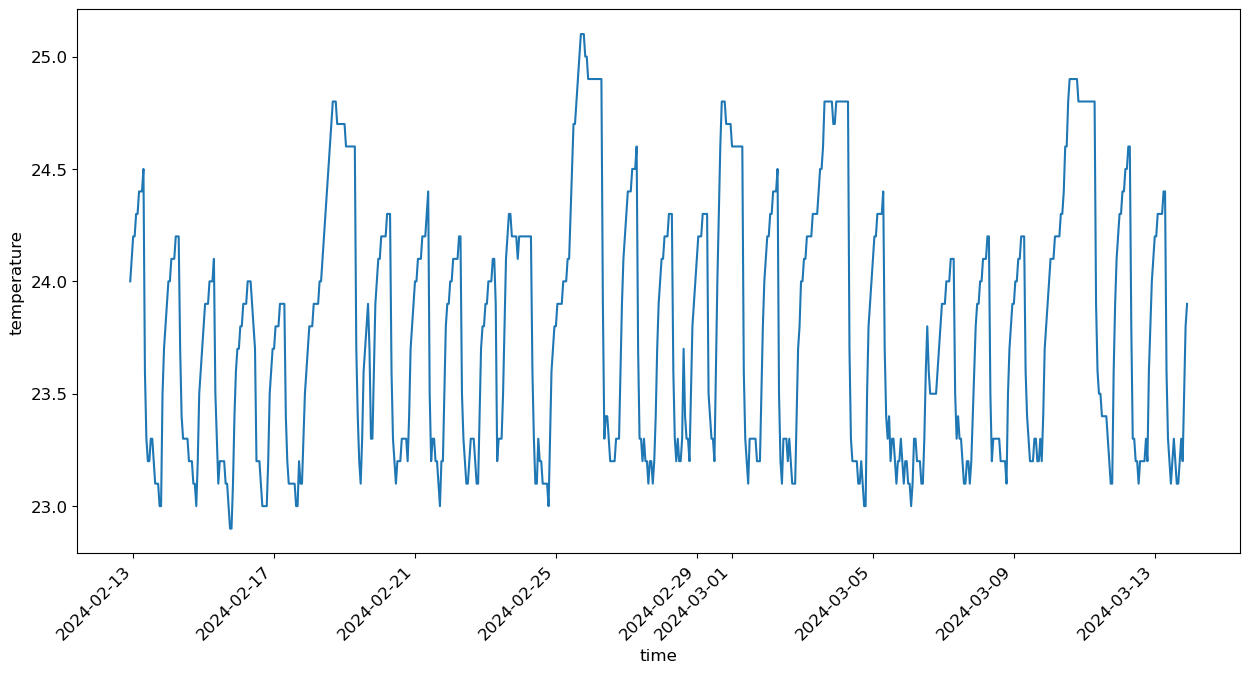

In [355]:
temperature.plot(y='temperature', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('time', fontsize=12)
plt.ylabel('temperature', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets

In [356]:
train_size = int(0.8 * len(df))

In [357]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [358]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [359]:
train_start_dt, test_start_dt

(Timestamp('2024-02-12 22:00:00'), Timestamp('2024-03-07 23:00:00'))

In [360]:
df

,CO2 (ppm),Humidity (%H),PM10 (μg/m³),PM2.5 (μg/m³),Temperature (°C),TVOC (ppm)
Time,,,,,,
2024-02-12 22:00:00,456,79.0,5.60,5.60,24.0,0.642
2024-02-12 23:00:00,456,79.0,5.25,5.13,24.1,0.711
2024-02-13 00:00:00,456,79.0,6.00,5.89,24.2,0.744
2024-02-13 01:00:00,450,79.0,6.44,6.33,24.2,0.759
2024-02-13 02:00:00,447,79.0,6.25,5.88,24.3,0.775
...,...,...,...,...,...,...
2024-03-13 18:00:00,707,77.7,16.20,15.30,23.3,0.497
2024-03-13 19:00:00,657,78.0,20.20,19.50,23.2,0.423
2024-03-13 20:00:00,618,78.4,23.20,22.00,23.5,0.375


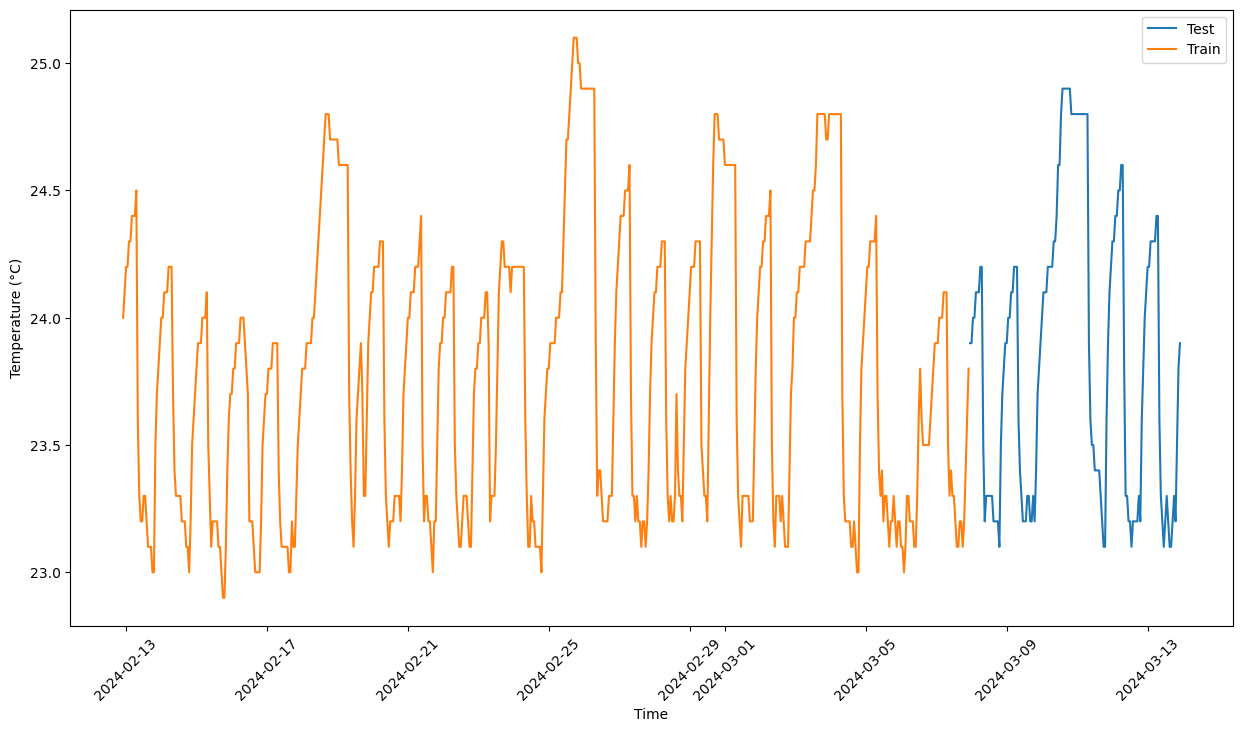

In [361]:
test_temperatures = df[df.index >= test_start_dt]["Temperature (°C)"]
train_temperatures = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["Temperature (°C)"]

plt.figure(figsize=(15, 8))
plt.plot(test_temperatures.index, test_temperatures.values, label='Test')

plt.plot(train_temperatures.index, train_temperatures.values, label='Train')

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [362]:
train_temperatures_reshaped = train_temperatures.values.reshape(-1, 1)
test_temperatures_reshaped = test_temperatures.values.reshape(-1, 1)

In [363]:
print("Training data shape: ", train_temperatures.shape)
print("Test data shape: ", test_temperatures.shape)

Training data shape:  (575,)
Test data shape:  (144,)


In [364]:
scaler = MinMaxScaler()
train_temperatures_scaled = scaler.fit_transform(train_temperatures_reshaped)
train_temperatures_scaled = pd.DataFrame(train_temperatures_scaled.flatten(), index=train_temperatures.index, columns=["Temperature (°C)"])
train_temperatures_scaled.head(10)

,Temperature (°C)
Time,
2024-02-12 22:00:00,0.500000
2024-02-12 23:00:00,0.545455
2024-02-13 00:00:00,0.590909
2024-02-13 01:00:00,0.590909
2024-02-13 02:00:00,0.636364
2024-02-13 03:00:00,0.636364
2024-02-13 04:00:00,0.681818
2024-02-13 05:00:00,0.681818
2024-02-13 06:00:00,0.681818


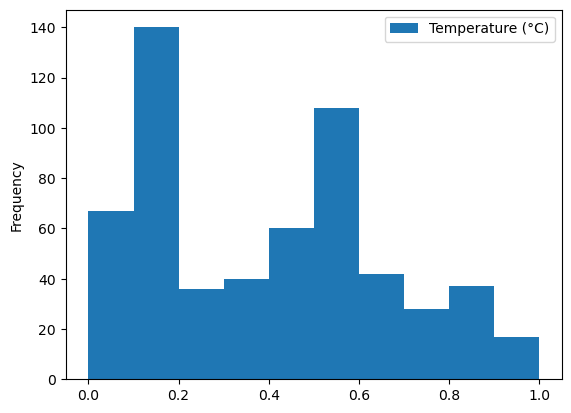

In [365]:
train_temperatures_scaled.plot.hist(bins=10)
plt.show()

In [366]:
test_temperatures_scaled = scaler.fit_transform(test_temperatures_reshaped)
test_temperatures_scaled = pd.DataFrame(test_temperatures_scaled.flatten(), index=test_temperatures.index, columns=["Temperature (°C)"])
test_temperatures_scaled.head(10)

,Temperature (°C)
Time,
2024-03-07 23:00:00,0.444444
2024-03-08 00:00:00,0.444444
2024-03-08 01:00:00,0.500000
2024-03-08 02:00:00,0.500000
2024-03-08 03:00:00,0.555556
2024-03-08 04:00:00,0.555556
2024-03-08 05:00:00,0.555556
2024-03-08 06:00:00,0.611111
2024-03-08 07:00:00,0.611111


In [440]:
HORIZON = 3

In [441]:
stepwise_fit_temp = auto_arima(train_temperatures_scaled, trace=True, suppress_warnings=True)
stepwise_fit_temp.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1234.701, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.567, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1171.108, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-540.615, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=781.056, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1256.428, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-870.513, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1249.224, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-1258.066, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-1037.535, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-1258.794, Time=0.21 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-1263.878, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1259.716, Time=0.21 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-1256.219, Time=0.28 sec
 ARIMA(3,0,4)(0,0,0)[0] in

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  575
Model:               SARIMAX(3, 0, 3)   Log Likelihood                 639.939
Date:                Thu, 14 Mar 2024   AIC                          -1263.878
Time:                        15:45:33   BIC                          -1229.043
Sample:                             0   HQIC                         -1250.292
                                - 575                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0279      0.014      1.985      0.047       0.000       0.056
ar.L1          0.8136      0.414      1.966      0.049       0.002       1.625
ar.L2          0.8845      0.717      1.234      0.217      -0.520       2.289
ar.L3         -0.7666      0.340     -2.255      0.024      -1.433      -0.100
ma.L1          0.4932      0.414      1.192      0.233      -0.317       1.304
ma.L2         -0.6405      0.249     -2.568      0.010      -1.129      -0.152
ma.L3         -0.1955      0.104     -1.873      0.061      -0.400       0.009
sigma2         0.0064      0.000     15.404      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):              3649.91
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -2.67
Prob(H) (two-sided):                  0.04   Kurtosis:                        14.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [443]:
order = (3,0,3)

In [444]:
model_temp =  ARIMA(train_temperatures_scaled, order=order)
result_temp = model_temp.fit()

print(result_temp.summary())

                               SARIMAX Results                                
Dep. Variable:       Temperature (°C)   No. Observations:                  575
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 639.815
Date:                Thu, 14 Mar 2024   AIC                          -1263.630
Time:                        15:45:43   BIC                          -1228.795
Sample:                             0   HQIC                         -1250.044
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4011      0.046      8.709      0.000       0.311       0.491
ar.L1          0.9954      3.427      0.290      0.771      -5.722       7.713
ar.L2          0.5556      6.006      0.092      0.9

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [449]:
test_temp_shifted = test_temperatures_scaled.copy()

for t in range(1, HORIZON):
    test_temp_shifted["Temperature (°C)+" + str(t)] = test_temp_shifted["Temperature (°C)"].shift(-t, freq='H')
    
test_temp_shifted = test_temp_shifted.dropna(how='any')
test_temp_shifted.head()

,Temperature (°C),Temperature (°C)+1,Temperature (°C)+2
Time,,,
2024-03-07 23:00:00,0.444444,0.444444,0.500000
2024-03-08 00:00:00,0.444444,0.500000,0.500000
2024-03-08 01:00:00,0.500000,0.500000,0.555556
2024-03-08 02:00:00,0.500000,0.555556,0.555556
2024-03-08 03:00:00,0.555556,0.555556,0.555556


Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [450]:
stepwise_fit_temp_test = auto_arima(test_temperatures_scaled, trace=True, suppress_warnings=True)
stepwise_fit_temp_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-251.375, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=84.951, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-233.039, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-69.910, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=227.791, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-253.815, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-158.504, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-254.151, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-255.154, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-257.113, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-255.129, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-253.198, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-251.505, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.328 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 132.556
Date:                Thu, 14 Mar 2024   AIC                           -257.113
Time:                        15:46:19   BIC                           -245.234
Sample:                    03-07-2024   HQIC                          -252.286
                         - 03-13-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0343      0.018      1.962      0.050     3.3e-05       0.069
ar.L1          1.3237      0.139      9.553      0.000       1.052       1.595
ar.L2         -0.4044      0.137     -2.960      0.003      -0.672      -0.137
sigma2         0.0091      0.001      8.334      0.000       0.007       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               610.76
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -2.24
Prob(H) (two-sided):                  0.24   Kurtosis:                        12.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [451]:
test_temp_shifted

,Temperature (°C),Temperature (°C)+1,Temperature (°C)+2
Time,,,
2024-03-07 23:00:00,0.444444,0.444444,0.500000
2024-03-08 00:00:00,0.444444,0.500000,0.500000
2024-03-08 01:00:00,0.500000,0.500000,0.555556
2024-03-08 02:00:00,0.500000,0.555556,0.555556
2024-03-08 03:00:00,0.555556,0.555556,0.555556
...,...,...,...
2024-03-13 16:00:00,0.000000,0.055556,0.111111
2024-03-13 17:00:00,0.055556,0.111111,0.055556
2024-03-13 18:00:00,0.111111,0.055556,0.222222


In [480]:
%%time
training_window = 24

train_ts = train_temperatures_scaled["Temperature (°C)"]
test_ts = test_temp_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions_temp = list()

order = (2, 0, 0)

for t in range(test_ts.shape[0]):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions_temp.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-07 23:00:00
1 : predicted = [0.43324132 0.42978963 0.4167426 ] expected = [0.44444444444444287, 0.44444444444444287, 0.5]
2024-03-08 00:00:00
2 : predicted = [0.44338131 0.42886212 0.41131404] expected = [0.44444444444444287, 0.5, 0.5]
2024-03-08 01:00:00
3 : predicted = [0.4277588  0.40695319 0.38756931] expected = [0.5, 0.5, 0.5555555555555571]
2024-03-08 02:00:00
4 : predicted = [0.50308003 0.48624236 0.46410294] expected = [0.5, 0.5555555555555571, 0.5555555555555571]
2024-03-08 03:00:00
5 : predicted = [0.48063857 0.45652613 0.43378502] expected = [0.5555555555555571, 0.5555555555555571, 0.5555555555555571]
2024-03-08 04:00:00
6 : predicted = [0.5531618  0.52917592 0.49997635] expected = [0.5555555555555571, 0.5555555555555571, 0.6111111111111107]
2024-03-08 05:00:00
7 : predicted = [0.53511837 0.50945967 0.48479746] expected = [0.5555555555555571, 0.6111111111111107, 0.6111111111111107]
2024-03-08 06:00:00
8 : predicted = [0.53530912 0.50988961 0.48544434] expected = [0.6

2024-03-10 12:00:00
62 : predicted = [0.87452276 0.88384206 0.87883826] expected = [0.8333333333333339, 0.9444444444444464, 1.0]
2024-03-10 13:00:00
63 : predicted = [0.82374003 0.81047677 0.796035  ] expected = [0.9444444444444464, 1.0, 1.0]
2024-03-10 14:00:00
64 : predicted = [0.98011877 0.98526367 0.97824034] expected = [1.0, 1.0, 1.0]
2024-03-10 15:00:00
65 : predicted = [1.0145221  1.01063051 0.99871502] expected = [1.0, 1.0, 1.0]
2024-03-10 16:00:00
66 : predicted = [0.9910734  0.97853177 0.96469588] expected = [1.0, 1.0, 1.0]
2024-03-10 17:00:00
67 : predicted = [0.99174415 0.98009608 0.96719785] expected = [1.0, 1.0, 1.0]
2024-03-10 18:00:00
68 : predicted = [0.98849102 0.97142596 0.95200897] expected = [1.0, 1.0, 0.9444444444444464]
2024-03-10 19:00:00
69 : predicted = [0.9917259  0.97851186 0.96248904] expected = [1.0, 0.9444444444444464, 0.9444444444444464]
2024-03-10 20:00:00
70 : predicted = [0.99242239 0.98062662 0.96660763] expected = [0.9444444444444464, 0.944444444444

2024-03-13 15:00:00
137 : predicted = [0.06188662 0.09104791 0.12509467] expected = [0.0, 0.0, 0.05555555555555358]
2024-03-13 16:00:00
138 : predicted = [0.0110676  0.04655437 0.08696834] expected = [0.0, 0.05555555555555358, 0.11111111111111072]
2024-03-13 17:00:00
139 : predicted = [0.03198858 0.07232713 0.1107895 ] expected = [0.05555555555555358, 0.11111111111111072, 0.05555555555555358]
2024-03-13 18:00:00
140 : predicted = [0.1130796  0.16314338 0.20284611] expected = [0.11111111111111072, 0.05555555555555358, 0.22222222222222143]
2024-03-13 19:00:00
141 : predicted = [0.15896052 0.19661032 0.22418416] expected = [0.05555555555555358, 0.22222222222222143, 0.3888888888888893]
2024-03-13 20:00:00
142 : predicted = [0.05834464 0.08499427 0.11836339] expected = [0.22222222222222143, 0.3888888888888893, 0.44444444444444287]
CPU times: user 3.13 s, sys: 45.9 ms, total: 3.18 s
Wall time: 1.62 s


Compare the prediction against the actual Temperature.

In [481]:
eval_df = pd.DataFrame(predictions_temp, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['Timestamp'] = test_temperatures_scaled.index[0:len(test_temperatures_scaled.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='Timestamp', value_name='Prediction', var_name='H')
eval_df['Actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df[['Prediction', 'Actual']])
eval_df.head()

,Timestamp,H,Prediction,Actual
0,2024-03-07 23:00:00,t+1,23.879834,23.9
1,2024-03-08 00:00:00,t+1,23.898086,23.9
2,2024-03-08 01:00:00,t+1,23.869966,24.0
3,2024-03-08 02:00:00,t+1,24.005544,24.0
4,2024-03-08 03:00:00,t+1,23.965149,24.1


Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [482]:
if (HORIZON > 1):
    eval_df['APE'] = (eval_df['Prediction'] - eval_df['Actual']).abs()
    print(eval_df.groupby('H')['APE'].mean())

H
t+1    0.105283
t+2    0.213551
t+3    0.300306
Name: APE, dtype: float64


In [471]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [483]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['H'] == 't+1']['Prediction'], eval_df[eval_df['H'] == 't+1']['Actual']))*100, '%')

One step forecast MAPE:  0.4441757738589723 %


In [484]:
print('Multi-step forecast MAPE: ', mape(eval_df['Prediction'], eval_df['Actual'])*100, '%')

Multi-step forecast MAPE:  0.8710220608467575 %


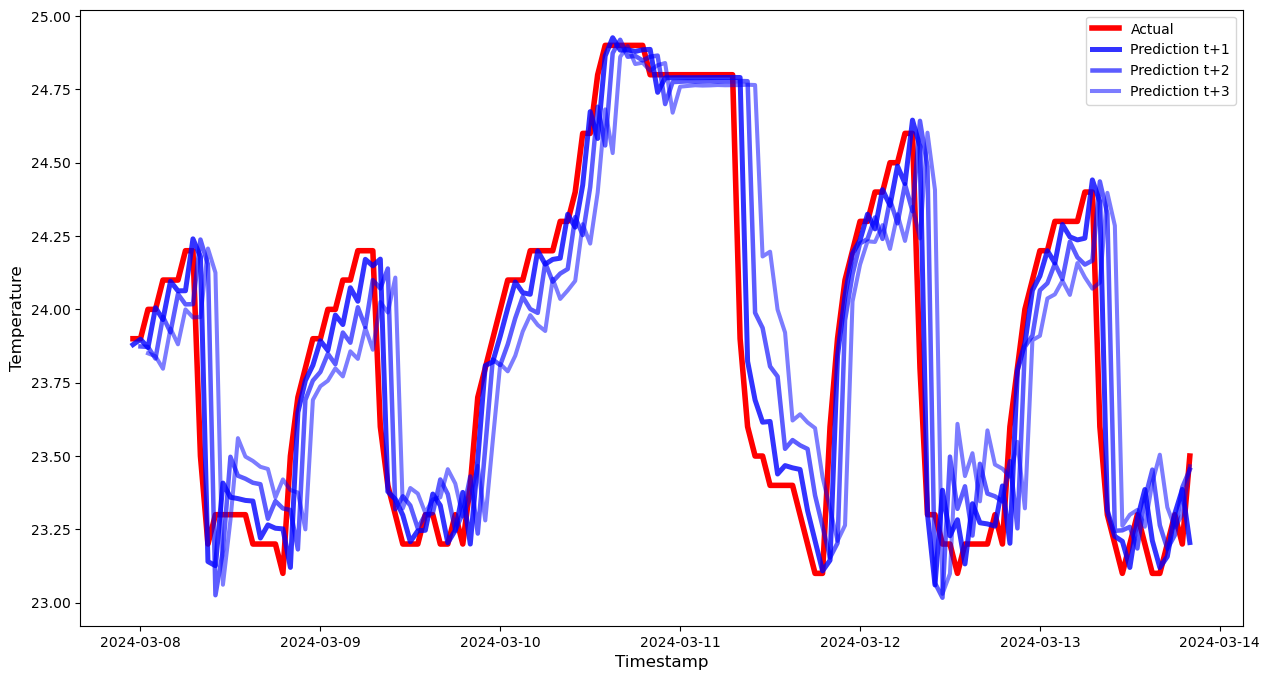

In [485]:
if HORIZON == 1:
    eval_df.plot(x='Timestamp', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Temperature', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df = eval_df[(eval_df.H == 't+1')][['Timestamp', 'Actual']]
    for t in range(1, HORIZON + 1):
        plot_df['t+' + str(t)] = eval_df[(eval_df.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df['Timestamp'], plot_df['Actual'], color='red', linewidth=4.0, label='Actual')  # Specify label for actual data
    for t in range(1, HORIZON + 1):
        x = plot_df['Timestamp'][(t - 1):]
        y = plot_df['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Temperature', fontsize=12)
    plt.show()

In [489]:
df.index[-1]

Timestamp('2024-03-13 22:00:00')